# Net generation and investigation of 2d net-generated cluster 

In [374]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import random

## Grid generation with and without shell

In [375]:
def generate_filled_grid(n, fill_prob):
    return np.random.choice([0, 1], size=(n, n, n), p=[1 - fill_prob, fill_prob])

def generate_filled_grid_with_shell(n, node_prob, shell_prob):
    size_with_shells = n * 3
    nodes_index_range = range(1, size_with_shells, 3)

    res = np.zeros(shape=(size_with_shells, size_with_shells, size_with_shells), dtype=int)
    
    for i in nodes_index_range:
        for j in nodes_index_range:
            for k in nodes_index_range:     
                if random() <= node_prob:
                    res[i, j, k] = 1
                    if random() <= shell_prob:
                        res[i + 1, j, k] = 1
                    if random() <= shell_prob:
                        res[i - 1, j, k] = 1
                    if random() <= shell_prob:
                        res[i, j + 1, k] = 1
                    if random() <= shell_prob:
                        res[i, j - 1, k] = 1
                    if random() <= shell_prob:
                        res[i, j, k + 1] = 1
                    if random() <= shell_prob:
                        res[i, j, k - 1] = 1
    return res
    

In [376]:
def split_voxels(n, grid):
    res_nodes = np.full((n * 3, n * 3, n * 3), False)
    res_shells = np.full((n * 3, n * 3, n * 3), False)

    size_with_shells = n * 3
    nodes_index_range = range(1, size_with_shells, 3)
    

    for i in nodes_index_range:
        for j in nodes_index_range:
            for k in nodes_index_range:
                if grid[i, j, k] == 1:
                    res_nodes[i, j, k] = True
                    res_shells[i - 1, j, k] = grid[i - 1, j, k] == 1
                    res_shells[i + 1, j, k] = grid[i + 1, j, k] == 1
                    res_shells[i, j - 1, k] = grid[i, j - 1, k] == 1
                    res_shells[i, j + 1, k] = grid[i, j + 1, k] == 1
                    res_shells[i, j, k - 1] = grid[i, j, k - 1] == 1
                    res_shells[i, j, k + 1] = grid[i, j, k + 1] == 1

    return res_nodes, res_shells

In [377]:
def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

def get_indices_for_faces(res_voxel):
    x, y, z = np.indices(np.array(res_voxel_e.shape) + 1).astype(float) 
    x[2::6, :, :] -= 1.5
    x[3::6, :, :] += 1.5
    x[4::6, :, :] += 0.5
    x[5::6, :, :] += 0.5
    x[6::6, :, :] -= 0.5
    
    y[:, 2::6, :] -= 1.5
    y[:, 3::6, :] += 1.5
    y[:, 4::6, :] += 0.5
    y[:, 5::6, :] += 0.5
    y[:, 6::6, :] -= 0.5

    z[:, :, 2::6] -= 1.5
    z[:, :, 3::6] += 1.5
    z[:, :, 4::6] += 0.5
    z[:, :, 5::6] += 0.5
    z[:, :, 6::6] -= 0.5
    return x, y, z

In [426]:
def display_array(raw_arr, figure, vmin=None, vmax=None):
    arr = np.zeros(raw_arr.shape)

    print(n)

    for i in range(n * 3):
        for j in range(n * 3):
            for k in range(n * 3):
                arr[i, j, k] = raw_arr[k, n * 3 - j - 1, i]

    node_voxels, shell_voxels = split_voxels(n, arr)

    res_voxel = node_voxels | shell_voxels

    facecolors = np.empty(res_voxel.shape, dtype=object)
    edgecolors = np.empty(res_voxel.shape, dtype=object)

    facecolors[shell_voxels] = '#cccccc48'
    facecolors[node_voxels] = '#000000'

    res_voxel_e = explode(res_voxel)
    facecolors_e = explode(facecolors)
    x, y, z = get_indices_for_faces(res_voxel)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.voxels(x,y,z,res_voxel_e, facecolors=facecolors_e) 

    plt.show()

In [384]:
grid = generate_filled_grid_with_shell(n, 0.5, 0.5)

2


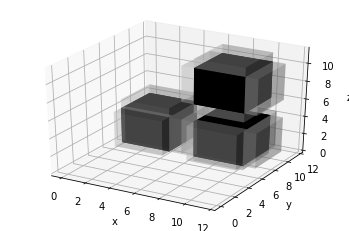

In [427]:
display_array(grid, "fig")

In [ ]:
def fill_marker_grid(arr):
    for i in range()

In [352]:
test = np.zeros(shape=(3, 3, 3))
for i in range(3):
    for j in range(3): 
        for k in range(3):
            test[i, j, k] = i * 9 + j * 3 + k + 1
print(test)
print(test[0, :, 2])

[[[ 1.  2.  3.]
  [ 4.  5.  6.]
  [ 7.  8.  9.]]

 [[10. 11. 12.]
  [13. 14. 15.]
  [16. 17. 18.]]

 [[19. 20. 21.]
  [22. 23. 24.]
  [25. 26. 27.]]]
[3. 6. 9.]
